# RED ID - 824667643 -> Class project - CS 696 - Spring 2020

<a href="https://github.com/AjaySankar/home_credit_risk"> Github link of the project </a>

# Loan risk assessment

## Goal

## Can you predict if an applicant is capable of repaying the loan ?

## Introduction 

<p>
    Loans are one of the major sources of income of banks. Hence, the primary aim of a banker/lender is to 
    predict if the applicant can completely repay the loan.
</p>

<p>
    The <a href="https://www.kaggle.com/c/home-credit-default-risk" target="_blank"> kaggle competition </a> of Home Credit primary goal is to build a machine learning model that can predict
    the risk involved in approving a loan.
</p>

<p>
    This helps banks increase their revenue by giving loans to genuine clients such there is less chance of default risk and also genuine clients get benefited by getting loans.
</p>

## Special Instructions before executing the notebook

## Downgrading Pyspark to 2.3.2

I was getting the following JVM error while creating a spark session.

<b> Downgrading the pyspark version to 2.3.2 has resolved the issue. </b>

https://stackoverflow.com/questions/53161939/pyspark-error-does-not-exist-in-the-jvm-error-when-initializing-sparkcontext

<code> pip install pyspark==2.3.2 </code>

## Downloading datasets...

Since Kaggle does not allow downloading datasets via curl, as it requires API token authentication. <br/>
However, We can still download dataset from Jupyter notebook.

Follwing article describes how to download datasets from Jupyter notebook. <br/>
https://medium.com/@jeff.daniel77/accessing-the-kaggle-com-api-with-jupyter-notebook-on-windows-d6f330bc6953

Steps in the above:

<ul>
    <li> <code> pip install kaggle </code> </li>
    <li> 
        Create a kaggle account and go to <b> https://www.kaggle.com/ReplaceYourUserNameHere/account </b> <br/>
        Click on "<b> Create New API Token </b>" to download your API token as <b> "kaggle.json" </b>
    </li>
    <li> Create a new directory ".kaggle" in your home directory (where python is installed) </li>
    <code> mkdir ~/.kaggle </code>
    <li> Copy <b>kaggle.json</b> from downloads to the created ".kaggle" directory </li>
    <code> chmod 600 /YourHomeDirectoryHere/.kaggle/kaggle.json </code>
</ul>

### OR

Download <i><b> application_train.csv </b></i> and <i><b> application_test.csv </b></i> from https://www.kaggle.com/c/home-credit-default-risk/data

### OR

#### Drive links
1.https://drive.google.com/open?id=1DUd3Du-uvAf6ZyW3rd6DliKILJ948liL <br/> <br/>
2.https://drive.google.com/open?id=1KSsoc9lez6QdUl36OZRFI26qiLBGAvEp

In [1]:
# Downloading datasets

import kaggle
!kaggle competitions download -c home-credit-default-risk -f application_train.csv
!kaggle competitions download -c home-credit-default-risk -f application_test.csv

100%|█████████████████████████████████████▉| 36.0M/36.1M [00:08<00:00, 5.21MB/s]
100%|██████████████████████████████████████| 36.1M/36.1M [00:08<00:00, 4.70MB/s]
100%|██████████████████████████████████████| 5.81M/5.81M [00:01<00:00, 4.08MB/s]
100%|██████████████████████████████████████| 5.81M/5.81M [00:01<00:00, 4.37MB/s]


In [2]:
# Unzipping datasets

!unzip application_train.csv.zip
!unzip application_test.csv.zip

Archive:  application_train.csv.zip
  inflating: application_train.csv   
Archive:  application_test.csv.zip
  inflating: application_test.csv    


## Dataset description

<p>
    The dataset includes the personal information and credit history of the applicant.
    They are distributed across different csv files such as application_{train|test}.csv, credit_card_balance.csv,
    previous_application.csv.
</p>

<p> 
    I will be focusing more on the basic and first hand information available to the banker about the applicant's
    credit history. This data is populated in the application_{train|test}.csv
</p>

## Business description of the problem

<ul>
    <li> The model should predict if an applicant is capable of repaying the loan. </li>
    <li> The model should avoid/reduce the mistakes of marking an incapable applicant as capable
        to repay the loan.
</ul>
    

## Machine Learning description

<p>
    This problem falls under the region of binary classification (can/cannot repay the loan) of machine learning
    problems.
</p>

<p> 
    The class label in the dataset is either <b> 0 (applicants who were able to pay back their loans) or 1 (applicants who were NOT able to pay back their loans). </b>
</p>

## Performance Metric

<p> 
    As per the business requirement, I can infer that AUC will serve our purpose. So we will use <b> ROC-AUC </b> as the performance metric.
    
</p>

## Find Spark Home
<b> Find the SPARK home path and initialize the below "SPARK_HOME" with it. </b>

In [3]:
SPARK_HOME = "/Users/ajaysankarreddychintagunta/spark-3.0.0-preview2-bin-hadoop2.7"

In [4]:
import findspark
from pyspark.sql import SparkSession
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.ml import Pipeline
from pyspark.sql.functions import mean,round,rank,sum,col
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import GBTClassifier, RandomForestClassifier, LogisticRegression, MultilayerPerceptronClassifier, DecisionTreeClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

## To print everything in a cell, not just the last print statement ##
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

findspark.init(SPARK_HOME)

### Create a spark session

In [5]:
spark = SparkSession.builder.appName('HomeCreditLoanRiskEstimation').getOrCreate()
loan_history_df = spark.read.csv('application_train.csv', header=True, inferSchema=True)

### Imbalanced class

<p>
    Sk_ID_Curr is the id column which we dont need it in the process #so we get rid of it. 
    And we rename the name of our target variable to "label"
</p>

<p>
    According to the dataset description, label -> 1 indicates that the loan is NOT paid in time, 
    and the label -> 0 indicates that the loan has been repaid well within the time window.
</p>

<p>
    The following counts of each class indicates that 90% of the data belong to class 0 which
    indicates that the classes are imbalanced.
</p>

<p>
    Various techniques are implemented to handle this problem. Will handle this later.
</p>

In [6]:
drop_col = ['SK_ID_CURR']
loan_history_df = loan_history_df.select([
    column for column in loan_history_df.columns if column not in drop_col])
loan_history_df = loan_history_df.withColumnRenamed('TARGET', 'label')
loan_history_df.groupby('label').count().toPandas()

,label,count
0,1,24825
1,0,282686


Training data shape:  (307511, 121)


<Figure size 864x720 with 0 Axes>

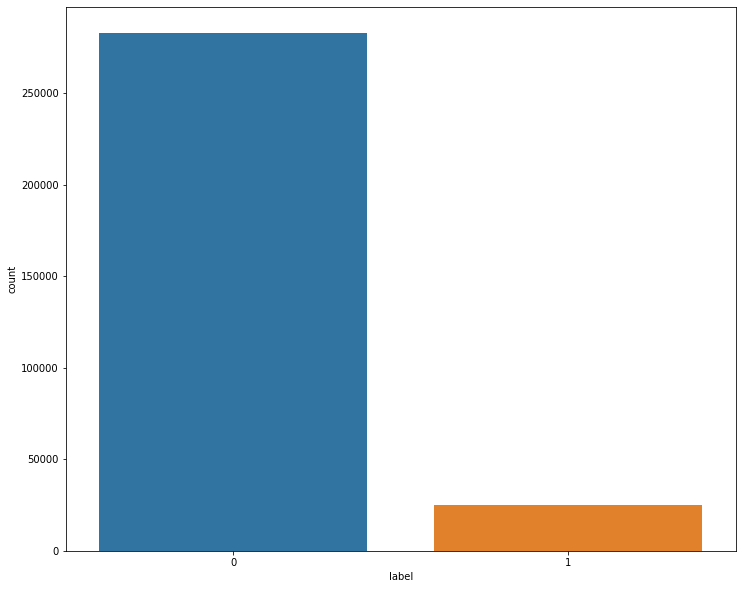

In [7]:
loan_history_df_pandas = loan_history_df.toPandas()
print('Training data shape: ', loan_history_df_pandas.shape)
plt.figure(figsize=(12,10))
sns.countplot(x='label', data=loan_history_df_pandas, order=loan_history_df_pandas['label'].value_counts().index)

In [8]:
loan_history_df_pandas.head(10)

,label,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
5,0,Cash loans,M,N,Y,0,99000.0,490495.5,27517.5,454500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0
6,0,Cash loans,F,Y,Y,1,171000.0,1560726.0,41301.0,1395000.0,...,0,0,0,0,0.0,0.0,0.0,1.0,1.0,2.0
7,0,Cash loans,M,Y,Y,0,360000.0,1530000.0,42075.0,1530000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
8,0,Cash loans,F,N,Y,0,112500.0,1019610.0,33826.5,913500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
9,0,Revolving loans,M,N,Y,0,135000.0,405000.0,20250.0,405000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
print(list(loan_history_df_pandas.columns))

['label', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'E

### Correlations between features

<p>
    The dataset consists of 120 features.
</p>

In [10]:
correlations = loan_history_df_pandas.corr()['label'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 DEF_60_CNT_SOCIAL_CIRCLE       0.031276
DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
OWN_CAR_AGE                    0.037612
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_BIRTH                     0.078239
label                          1.000000
Name: label, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED                -0.044932
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645
R

### Data Exploration

<span>
    The dataset contains both numerical and categorical features. <br/><br/>
    Since numerical features such as credit_amount, income of the applicant are spread across a huge range
    of values, binning them and then analysing them would be a more intuitive way.<br/><br/>
    Following utility functions help in binning and plotting the data.<br/><br/>
    I have choosen the following metrics to inspect the bins
    <ul>
        <li> Top bins based on the number of loans approved. </li>
        <li> Top bins based on the percentage of unpaid loans. </li>
    </ul>
</span>

##### Utility Fuctions

In [11]:
def classCountsInAnInterval(sub_df, interval):
    """ Returns the total number of instances of  paid/unpaid loans in a given interval """
    """ Input: Dataframe with class counts of the interval passed """
    class0, class1 = 0, 0
    # This check to handle cases where few intervals have only either paid/un-paid loans.
    if np.isscalar(sub_df[sub_df["loan_paid_status"] == 1]):
        class0 = class0 + sub_df[sub_df["loan_paid_status"] == 0]
        class1 = class1 + sub_df[sub_df["loan_paid_status"] == 1]
    else:
        class0 = class0 + int(sub_df[sub_df["loan_paid_status"] == 0]['count'])
        class1 = class1 + int(sub_df[sub_df["loan_paid_status"] == 1]['count'])
    return (class0+class1, class1, interval)

In [12]:
def getIntervalBasedCounts(df, category, no_of_bins=50):
    """ Input: A continous numerical category """
    """ Create bins from the category data points and count total loans, unpaid loans for each bin """
    
    # Create bins #
    continous_numerical_category = category
    binned_columns_name = continous_numerical_category + '_BINNED'
    credit_and_loan_df = pd.DataFrame(data={'loan_paid_status': df['label'], 
                                     continous_numerical_category: df[continous_numerical_category] })
    credit_and_loan_df[binned_columns_name] = pd.cut(credit_and_loan_df[continous_numerical_category], 
                                                     bins = np.linspace(
                                                         min(credit_and_loan_df[continous_numerical_category]), 
                                                         max(credit_and_loan_df[continous_numerical_category]), 
                                                         num = no_of_bins),
                                                     retbins=False)
    
    # Groupby "bin + loan_paid_status" and agg the size of each group.
    # This calculates the paid and unpaid loans counts in each bin.
    credit_and_loan_df = credit_and_loan_df.groupby([binned_columns_name, 'loan_paid_status']).size().to_frame()
    credit_and_loan_df.reset_index(inplace=True)
    credit_and_loan_df.set_index(binned_columns_name, inplace=True)
    
    # Binned column is of  type "Categorical Index" which is not useful in that format. #
    # Converting the bins to string format so that we can plot better based on bin. #
    integer_intervals = list(map(lambda interval: (interval.left,interval.right), credit_and_loan_df.index))
    credit_and_loan_df['integer_intervals'] = list(map(lambda interval: 
                                                       str(int(interval[0])) + '-' + str(int(interval[1])), 
                                                       integer_intervals))
    credit_and_loan_df.reset_index(inplace=True)
    # Drop the bins column of type "Categorical Index"
    credit_and_loan_df = credit_and_loan_df.drop([binned_columns_name], axis=1)
    credit_and_loan_df.set_index('integer_intervals', inplace=True)
    credit_and_loan_df = credit_and_loan_df.rename(columns={0: "count"})
    
    # The dataframe looks like the following
    # bin1 - loan_paid_count
    # bin1 - loan_not_paid_count
    # bin2 - loan_paid_count
    # bin2 - loan_not_paid_count ...
    
    # Calculate the total loans and percentage of unpaid loans in each bin.
    totalCountAndUnpaidCountPerInterval = pd.DataFrame(list(map(lambda interval: 
                                                                classCountsInAnInterval(
                                                                    credit_and_loan_df.loc[interval], interval), 
                                                                list(set(credit_and_loan_df.index)))), 
                                                       columns=['Total Loans', 'Unpaid Loans', 
                                                                continous_numerical_category])
    totalCountAndUnpaidCountPerInterval['percentage_unpaid_loans'] = (totalCountAndUnpaidCountPerInterval['Unpaid Loans'] 
                                                                      / totalCountAndUnpaidCountPerInterval['Total Loans']) * 100
    return totalCountAndUnpaidCountPerInterval

In [13]:
def plotTotalAndUnpaidLoansPerBin(df, featureColumn, totalLoansColumn = "Total Loans", 
                                  unpaidLoansColumn = "Unpaid Loans", top_n_intervals=20, 
                                  figsize=(30, 30), transpose=False):
    """ Plots bins versus total number of loans and unpaid loans """
    total_axes_data = [featureColumn, totalLoansColumn]
    unpaid_axes_data = [featureColumn, unpaidLoansColumn]
    axes_labels = ["Number of loans", featureColumn]
    if transpose:
        axes_labels[0], axes_labels[1] = axes_labels[1], axes_labels[0]
        total_axes_data[0], total_axes_data[1] = total_axes_data[1], total_axes_data[0]
        unpaid_axes_data[0], unpaid_axes_data[1] = unpaid_axes_data[1], unpaid_axes_data[0]
    sns.set(style="whitegrid")
    df = df.sort_values(totalLoansColumn, ascending=False).head(top_n_intervals)
    # Initialize the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Plot the total loans
    sns.set_color_codes("pastel")
    sns.barplot(x=total_axes_data[0], y=total_axes_data[1], data=df, label="Total", color="b")

    # Plot the loans which were unpaid
    sns.set_color_codes("muted")

    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('xlabel', fontsize=20)
    plt.ylabel('ylabel', fontsize=20)

    sns.barplot(x=unpaid_axes_data[0], y=unpaid_axes_data[1], data=df, label="Unpaid Loans", color="b")

    # Add a legend and informative axis label
    ax.legend(ncol=2, loc="lower right", frameon=True)
    ax.set(ylabel=axes_labels[0], xlabel=axes_labels[1])
    sns.despine(left=True, bottom=True)

In [14]:
def plotPercentageUnpaidLoansPerBin(df, feature, top_n_intervals=20, figsize=(30, 30), transpose=False):
    """ Plots bins versus percentage of unpaid loans in that bin """
    font = {
        'weight' : 'bold',
        'size'   : 40
    }
    matplotlib.rc('font', **font)
    f, axes = plt.subplots(1, 1, figsize=figsize)
    axes_data = [feature, 'percentage_unpaid_loans']
    if transpose:
        axes_data[0], axes_data[1] = axes_data[1], axes_data[0]
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('xlabel', fontsize=20)
    plt.ylabel('ylabel', fontsize=20)
    df = df.sort_values('percentage_unpaid_loans',  ascending=False).head(top_n_intervals)
    ax = sns.barplot(x=axes_data[0], y=axes_data[1], data=df, ax=axes)
    return df

In [15]:
def processCategoricalFeature(df, category):
    df_category = pd.DataFrame(df, columns=[category, 'label'])
    df_category = df_category.groupby([category, 'label']).size().to_frame()
    df_category.reset_index(inplace=True)
    df_category.set_index(category, inplace=True)
    df_category.rename(columns={0: "count"}, inplace=True)
    df_category.rename(columns={'label': "loan_paid_status"}, inplace=True)
    df_category = pd.DataFrame(list(map(lambda interval: classCountsInAnInterval(df_category.loc[interval], interval), 
                                 list(set(df_category.index)))), 
                        columns=['Total Loans', 'Unpaid Loans', category])
    df_category['percentage_unpaid_loans'] = (df_category['Unpaid Loans'] / df_category['Total Loans']) * 100
    return df_category

#### DAYS_BIRTH

<p>
    The absolute value of the days_birth feature is the age of the applicant in days.
</p>

In [16]:
age_and_loan_df = pd.DataFrame(data={'loan_paid_status': loan_history_df_pandas['label'], 
                                     'age_of_applicant': loan_history_df_pandas['DAYS_BIRTH'] / -365})
age_and_loan_df
age_and_loan_df['age_of_applicant'].describe()

,loan_paid_status,age_of_applicant
0,1,25.920548
1,0,45.931507
2,0,52.180822
3,0,52.068493
4,0,54.608219
...,...,...
307506,0,25.553425
307507,0,56.917808
307508,0,41.002740
307509,1,32.769863


count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: age_of_applicant, dtype: float64

<Figure size 1440x720 with 0 Axes>

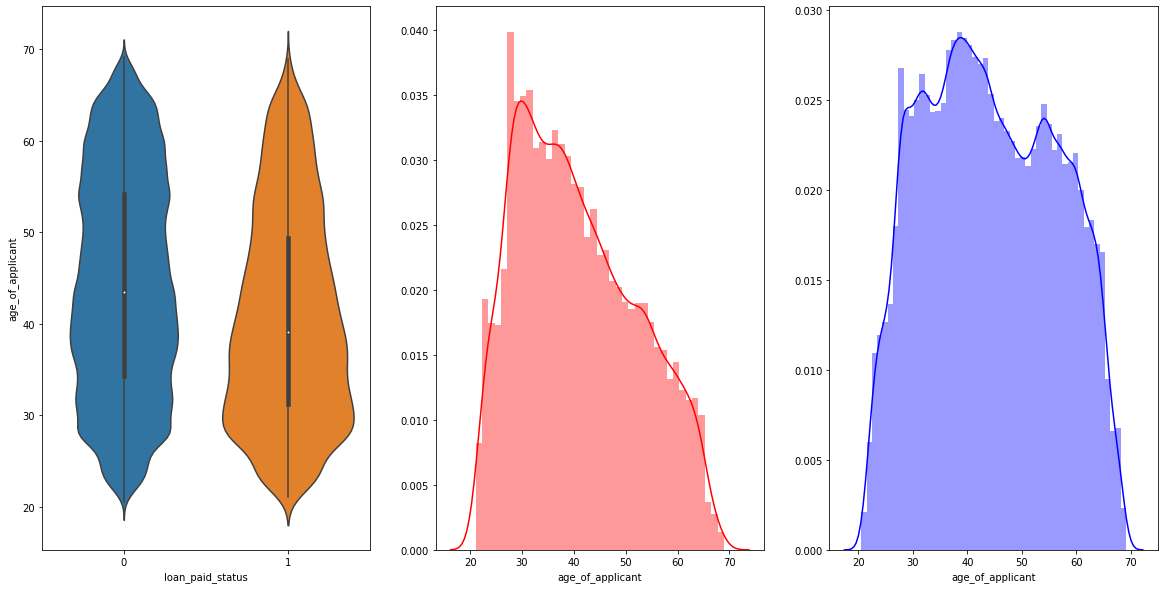

In [17]:
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
sns.violinplot(x='loan_paid_status', y='age_of_applicant', data=age_and_loan_df)
plt.subplot(1,3,2)
sns.distplot(age_and_loan_df[age_and_loan_df['loan_paid_status']==1]['age_of_applicant'], label='loan_not_paid', 
             color='red')
plt.subplot(1,3,3)
sns.distplot(age_and_loan_df[age_and_loan_df['loan_paid_status']==0]['age_of_applicant'], label='loan_paid', 
             color='blue')

<p>
    If you observe above distribution we can say that most people who are not able to repay loan are younger people.
</p>

<p>
    In the loan paid class, applicants in the age group 35-45 years are majority who have paid the loan.
</p>

In [18]:
# Bin the age data
age_and_loan_df['YEARS_BINNED'] = pd.cut(age_and_loan_df['age_of_applicant'], bins = np.linspace(20, 70, num = 11))
age_and_loan_df.head(10)
age_groups  = age_and_loan_df.groupby('YEARS_BINNED').mean()
age_groups

,loan_paid_status,age_of_applicant,YEARS_BINNED
0,1,25.920548,"(25.0, 30.0]"
1,0,45.931507,"(45.0, 50.0]"
2,0,52.180822,"(50.0, 55.0]"
3,0,52.068493,"(50.0, 55.0]"
4,0,54.608219,"(50.0, 55.0]"
5,0,46.413699,"(45.0, 50.0]"
6,0,37.747945,"(35.0, 40.0]"
7,0,51.643836,"(50.0, 55.0]"
8,0,55.065753,"(55.0, 60.0]"
9,0,39.641096,"(35.0, 40.0]"


,loan_paid_status,age_of_applicant
YEARS_BINNED,,
"(20.0, 25.0]",0.123036,23.377522
"(25.0, 30.0]",0.111436,27.822518
"(30.0, 35.0]",0.102814,32.479037
"(35.0, 40.0]",0.089414,37.555913
"(40.0, 45.0]",0.078491,42.459346
"(45.0, 50.0]",0.074171,47.462741
"(50.0, 55.0]",0.066968,52.593136
"(55.0, 60.0]",0.055314,57.491131
"(60.0, 65.0]",0.052737,62.412459


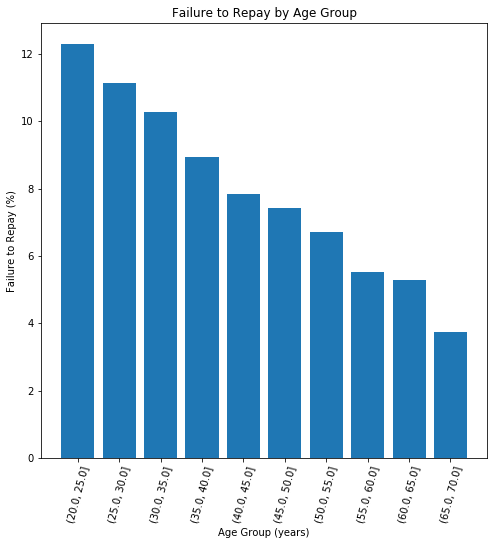

In [19]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['loan_paid_status'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

<p>
    There is a clear trend: younger applicants are more likely to not repay the loan!
</p>

<p>
    This is information that could be directly used by the bank: because younger clients are less likely to repay the loan, maybe they should be provided with more guidance or financial planning tips. The bankers to take precautionary measures to help younger clients pay on time.
</p>

#### AMT_CREDIT

In [20]:
totalCountAndUnpaidCountPerIntervalCreditAmount = getIntervalBasedCounts(loan_history_df_pandas, 
                                                                         "AMT_CREDIT",no_of_bins=50)

##### Removing outliers

<span>
    On finding the total loans in each bin, there are few outliers(bins) where the loan amount was higher, so fewer loans approved. <br/>
    Some of those bins had 2 loans approved and 1 loans has been repaid, resulting in a 50% unpaid percentage which is way above the avergae unpaid percentage 6%-8%. <br/> <br/>
    To handle such outliers, I have found the mean value of <b> "Number of loans in each bin" </b> and filtered
    the bins with atleast acceptable number of loans.
</span>

In [21]:
mean_number_loans = totalCountAndUnpaidCountPerIntervalCreditAmount['Total Loans'].mean()

# mean_value + 45% percent of mean_value
# mean_value - 45% percent of mean_value
threshold = 45

min_threshold = mean_number_loans - ((threshold/100) * mean_number_loans)
max_threshold = mean_number_loans + ((threshold/100) * mean_number_loans)

print("Mean of \"number of loans\" in each bin", mean_number_loans)

print("Filtering bins which are", "+", threshold, "% and", "-", threshold, "% of the mean")
print("Acceptable range ", min_threshold, "to", max_threshold, sep = ' ')

totalCountAndUnpaidCountPerIntervalCreditAmount = totalCountAndUnpaidCountPerIntervalCreditAmount[
        (totalCountAndUnpaidCountPerIntervalCreditAmount["Total Loans"] >= min_threshold) &
        (totalCountAndUnpaidCountPerIntervalCreditAmount["Total Loans"] <=max_threshold)]

Mean of "number of loans" in each bin 7316.214285714285
Filtering bins which are + 45 % and - 45 % of the mean
Acceptable range  4023.917857142857 to 10608.510714285714


##### Sort Credit-Amount by percentage of unpaid loans

,Total Loans,Unpaid Loans,AMT_CREDIT,percentage_unpaid_loans
22,9313,702,1025816-1107551,7.537850
38,8826,588,944081-1025816,6.662135
16,8671,533,1271020-1352755,6.146927
41,10251,612,45000-126734,5.970149
39,5668,336,1189285-1271020,5.928017
27,7907,413,1107551-1189285,5.223220


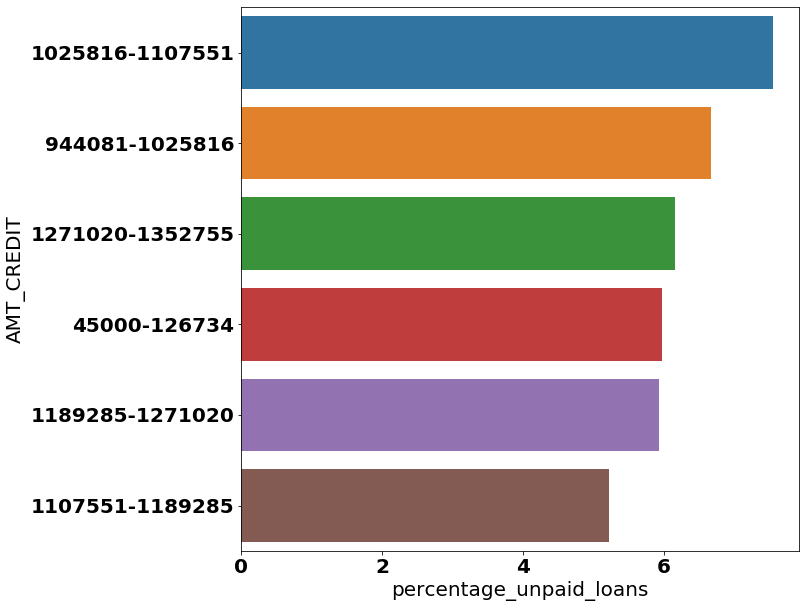

In [22]:
plotPercentageUnpaidLoansPerBin(totalCountAndUnpaidCountPerIntervalCreditAmount, "AMT_CREDIT", 
                                figsize=(10,10), transpose=True)

##### Sort Credit-Amount by number of loans approved

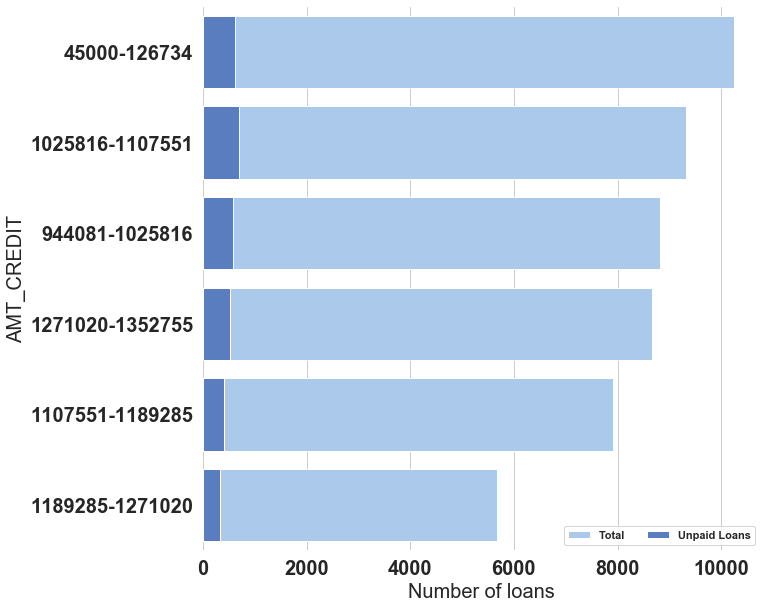

In [23]:
plotTotalAndUnpaidLoansPerBin(totalCountAndUnpaidCountPerIntervalCreditAmount, "AMT_CREDIT", figsize=(10,10), 
                              transpose = True)

count    3.075110e+05
mean     5.990260e+05
std      4.024908e+05
min      4.500000e+04
25%      2.700000e+05
50%      5.135310e+05
75%      8.086500e+05
max      4.050000e+06
Name: AMT_CREDIT, dtype: float64

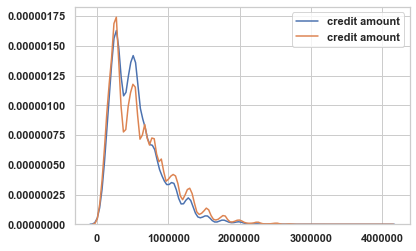

In [24]:
loan_history_df_pandas['AMT_CREDIT'].describe()
credit_amount_and_loan_df = pd.DataFrame(data={'loan paid status': loan_history_df_pandas['label'], 
                                     'credit amount': loan_history_df_pandas['AMT_CREDIT']})

# Unpaid loans graph - red colored plot
ax = sns.kdeplot(credit_amount_and_loan_df[credit_amount_and_loan_df['loan paid status']==1]['credit amount'])
# Paid loans graph - blue colored plot
sns.kdeplot(credit_amount_and_loan_df[credit_amount_and_loan_df['loan paid status']==0]['credit amount'], ax=ax)

##### Possible Conclusions

<span>
    <ul>
        <li>
            There is not much correlation between the loan amount and paid/unpaid status, as the percentage of unpaid loans is almost the same (5% to 7%) in all ranges of credit amount.
        </li>
        <li>
            Most of the loans are approved if the credit amount is in the range 45K to 120K.
        </li>
        <li>
            As the credit amount increases, the number of approved loans decreases.
        </li>
        <li>
            Although, more loans are approved in the range 45K to 120K, most of those loans
            were paid indicating that lower credit amount is a safer bet for the banks.
        </li>
    </ul>
</span>

#### DAYS_EMPLOYED

<span>
    The "DAYS_EMPLOYED" is the number of days before the loan application, the applicant has been working. <br/>
    Convert the days since employed to years since employed.
</span>

In [25]:
day_employed_filtered = pd.DataFrame(loan_history_df_pandas[loan_history_df_pandas['DAYS_EMPLOYED'] <= 0], 
                                     columns=['DAYS_EMPLOYED', 'label'])
day_employed_filtered['YEARS_EMPLOYED'] = day_employed_filtered['DAYS_EMPLOYED'] // -365

##### Sort Years_employed by percentage of unpaid loans

,Total Loans,Unpaid Loans,YEARS_EMPLOYED,percentage_unpaid_loans
6,124634,12665,0-5,10.161754
8,55983,3930,5-10,7.019988
7,25263,1371,10-16,5.426909
4,2423,115,27-32,4.746182
3,8856,419,16-21,4.731256
0,5313,229,21-27,4.310183
2,1402,36,32-38,2.567760
1,55,1,43-49,1.818182
5,304,4,38-43,1.315789


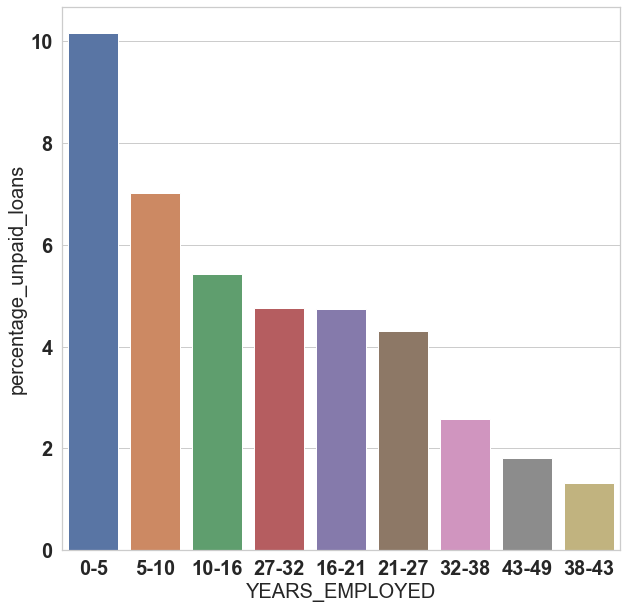

In [26]:
totalCountAndUnpaidCountPerIntervalMonthsEmployed = getIntervalBasedCounts(day_employed_filtered, 
                                                                             "YEARS_EMPLOYED",no_of_bins=10)
plotPercentageUnpaidLoansPerBin(totalCountAndUnpaidCountPerIntervalMonthsEmployed, "YEARS_EMPLOYED", figsize=(10,10))

##### Sort Years_employed by number of loans approved

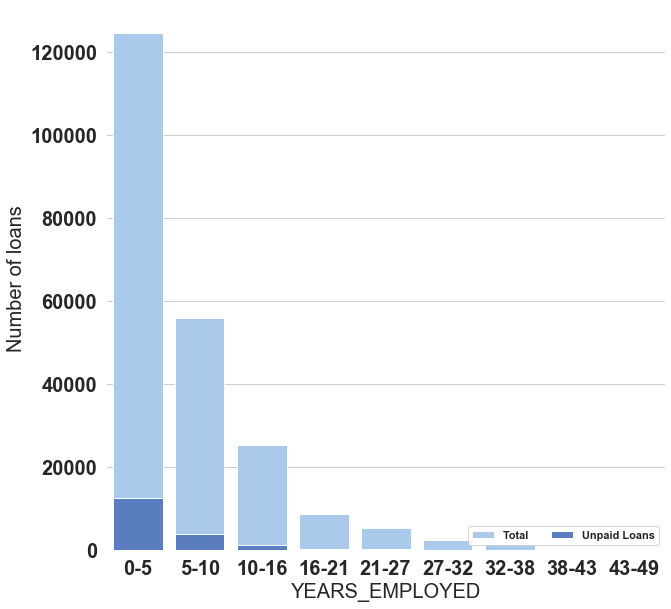

In [27]:
plotTotalAndUnpaidLoansPerBin(totalCountAndUnpaidCountPerIntervalMonthsEmployed, "YEARS_EMPLOYED", figsize=(10,10))

##### Possible Conclusions

<span>
    <ul>
        <li> Almost 50 percent of the loans were given to applicants employed in the last 10 years. </li>
        <li> The more number of years of employment, the higher chance of repaying the loans.
    </ul>
</span>

#### DAYS_LAST_PHONE_CHANGE

The number of days that have passed since applicant has changed phone. <br/>
This seems to be a rather strange feature, however it has fairly good correlation with the paid/unpaid status.

In [28]:
last_phone_change_df = pd.DataFrame(loan_history_df_pandas[loan_history_df_pandas['DAYS_LAST_PHONE_CHANGE'] <= 0], 
                  columns=['DAYS_LAST_PHONE_CHANGE', 'label'])
last_phone_change_df['YEARS_LAST_PHONE_CHANGE'] = last_phone_change_df['DAYS_LAST_PHONE_CHANGE'] // -365

In [29]:
totalCountAndUnpaidCountPerDaysLastPhoneChange = getIntervalBasedCounts(last_phone_change_df, 
                                                                           'YEARS_LAST_PHONE_CHANGE',no_of_bins=5)

,Total Loans,Unpaid Loans,YEARS_LAST_PHONE_CHANGE,percentage_unpaid_loans
3,95580,8496,0-2,8.888889
1,90121,5906,2-5,6.553412
0,27712,1493,5-8,5.387558
2,1646,76,8-11,4.617254


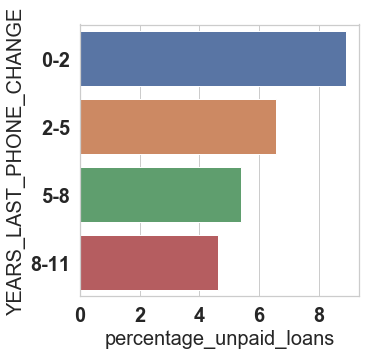

In [30]:
plotPercentageUnpaidLoansPerBin(totalCountAndUnpaidCountPerDaysLastPhoneChange, 'YEARS_LAST_PHONE_CHANGE', 
                                figsize=(5,5), transpose=True)

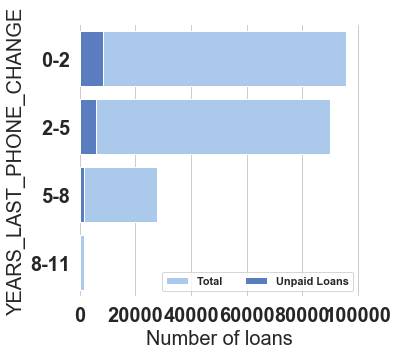

In [31]:
plotTotalAndUnpaidLoansPerBin(totalCountAndUnpaidCountPerDaysLastPhoneChange, 'YEARS_LAST_PHONE_CHANGE', 
                              figsize=(5,5), transpose = True)

##### Possible Conclusions

<ul>
    <li> More loans were applied by customers who have recently changed their phone. </li>
    <li> Higher percentage of unpaid loans also map to customers  recently changed their phone. </li>
    <li> This can highlight a quality that people who have not changed their phone are better at handling
        their finances and therefore required fewer loans and had higher loan repay rate.
    </li>
</ul>

#### REGION_RATING_CLIENT_W_CITY

<p>
    This is a categorical feature which seems to be some sort of rating given to a customer.
</p>

<p>
    There is not much information about this feature.
</p>

In [32]:
REGION_RATING_CLIENT_W_CITY_summary = processCategoricalFeature(loan_history_df_pandas, 
                                                                "REGION_RATING_CLIENT_W_CITY")
REGION_RATING_CLIENT_W_CITY_summary

,Total Loans,Unpaid Loans,REGION_RATING_CLIENT_W_CITY,percentage_unpaid_loans
0,34167,1654,1,4.840928
1,229484,18170,2,7.917763
2,43860,5001,3,11.402189


,Total Loans,Unpaid Loans,REGION_RATING_CLIENT_W_CITY,percentage_unpaid_loans
2,43860,5001,3,11.402189
1,229484,18170,2,7.917763
0,34167,1654,1,4.840928


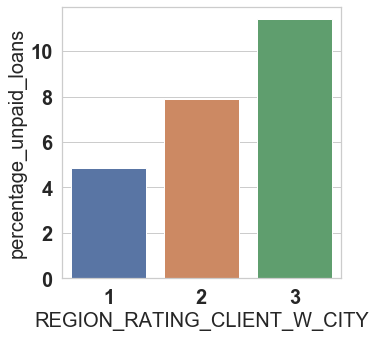

In [33]:
plotPercentageUnpaidLoansPerBin(REGION_RATING_CLIENT_W_CITY_summary, "REGION_RATING_CLIENT_W_CITY", figsize=(5,5))

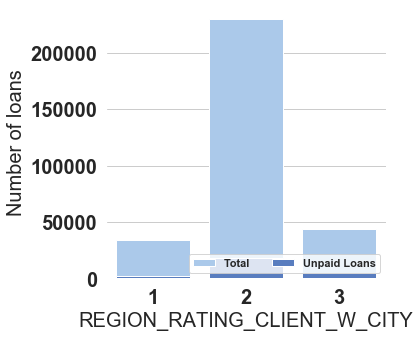

In [34]:
plotTotalAndUnpaidLoansPerBin(REGION_RATING_CLIENT_W_CITY_summary, "REGION_RATING_CLIENT_W_CITY", figsize=(5,5))

##### Possibel Conclusions

<span>
    <ul>
        <li>
            Most of the loans were approved to customers with REGION_RATING_CLIENT_W_CITY as 2.
        </li>
        <li>
            Although, almost same number of loans were given to customers with REGION_RATING_CLIENT_W_CITY as 1 and 3, customers with rating 3 have three time higher unpaid loan status.
        </li>
        <li>
            The bankers ought to be careful in approving loans to customers with rating 3.
        </li>
    </ul>
</span>

#### NAME_INCOME_TYPE

<p> Possible income types </p>

'Maternity leave',
 'State servant',
 'Student',
 'Businessman',
 'Unemployed',
 'Pensioner',
 'Commercial associate',
 'Working'

In [35]:
income_type_feature_summary = processCategoricalFeature(loan_history_df_pandas, "NAME_INCOME_TYPE")

threshold = 45

# Filter out income categories with atleast some number of loans.
min_threshold = mean_number_loans - ((threshold/100) * mean_number_loans)
print("Mean of \"number of loans\" in each bin", mean_number_loans)

income_type_feature_summary = income_type_feature_summary[(income_type_feature_summary["Total Loans"] >= min_threshold)]

Mean of "number of loans" in each bin 7316.214285714285


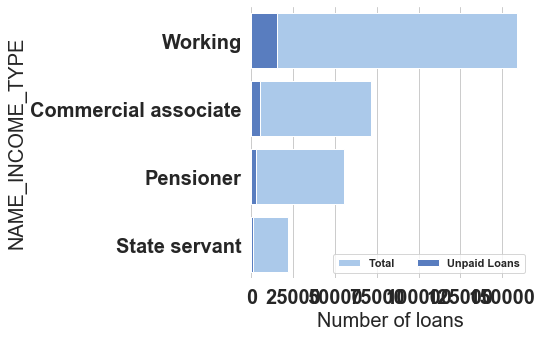

In [36]:
plotTotalAndUnpaidLoansPerBin(income_type_feature_summary, "NAME_INCOME_TYPE", figsize=(5,5), transpose=True)

,Total Loans,Unpaid Loans,NAME_INCOME_TYPE,percentage_unpaid_loans
7,158774,15224,Working,9.588472
6,71617,5360,Commercial associate,7.484257
1,21703,1249,State servant,5.754965
5,55362,2982,Pensioner,5.386366


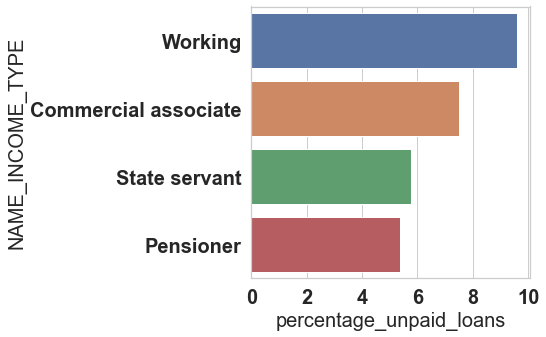

In [37]:
plotPercentageUnpaidLoansPerBin(income_type_feature_summary, "NAME_INCOME_TYPE", figsize=(5,5), transpose=True)

##### Possible Conclusions

<span>
    <ul>
        <li>
            Most of the loans are approved to "Working" class and they are also highly unpaid class.
        </li>
    </ul>
</span>

#### NAME_EDUCATION_TYPE
 'Incomplete higher',
 'Secondary / secondary special',
 'Academic degree',
 'Higher education',
 'Lower secondary'

In [38]:
education_type_summary = processCategoricalFeature(loan_history_df_pandas, "NAME_EDUCATION_TYPE")

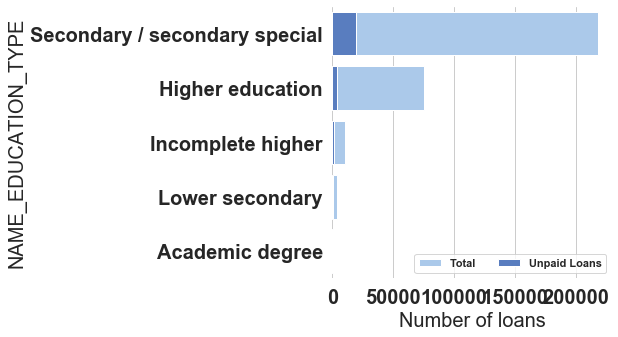

In [39]:
plotTotalAndUnpaidLoansPerBin(education_type_summary, "NAME_EDUCATION_TYPE", figsize=(5,5), transpose=True)

,Total Loans,Unpaid Loans,NAME_EDUCATION_TYPE,percentage_unpaid_loans
4,3816,417,Lower secondary,10.927673
1,218391,19524,Secondary / secondary special,8.939929
0,10277,872,Incomplete higher,8.484966
3,74863,4009,Higher education,5.355115
2,164,3,Academic degree,1.829268


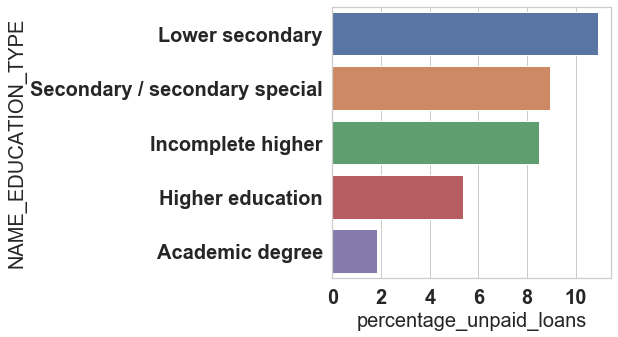

In [40]:
plotPercentageUnpaidLoansPerBin(education_type_summary, "NAME_EDUCATION_TYPE", figsize=(5,5), transpose=True)

##### Possible Conclusions

<span>
    <ul>
        <li>
            Most of the loans are approved to "Secondary Education" class and they are also highly unpaid class, <br/>possibly loans are for higher education, so they are unpaid.
        </li>
        <li>
            The higher the education of the applicant, there is a higher chance of loan repayment.
        </li>
    </ul>
</span>

#### NAME_FAMILY_STATUS

'Separated',
 'Widow',
 'Civil marriage',
 'Single / not married',
 'Unknown',
 'Married'

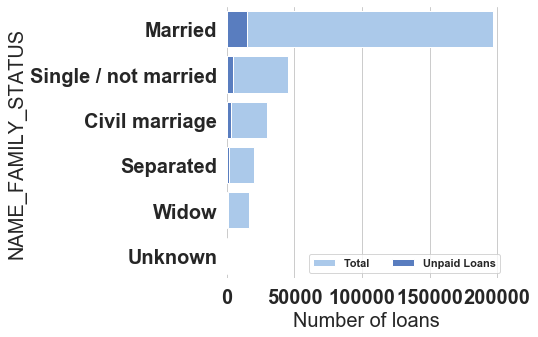

In [41]:
family_status_summary = processCategoricalFeature(loan_history_df_pandas, "NAME_FAMILY_STATUS")

plotTotalAndUnpaidLoansPerBin(family_status_summary, "NAME_FAMILY_STATUS", figsize=(5,5), transpose=True)

,Total Loans,Unpaid Loans,NAME_FAMILY_STATUS,percentage_unpaid_loans
2,29775,2961,Civil marriage,9.944584
3,45444,4457,Single / not married,9.807675
0,19770,1620,Separated,8.194234
5,196432,14850,Married,7.559868
1,16088,937,Widow,5.824217
4,2,0,Unknown,0.000000


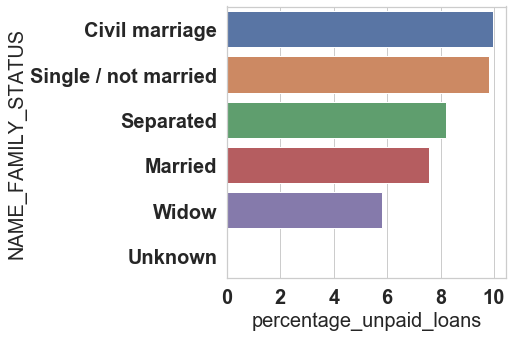

In [42]:
plotPercentageUnpaidLoansPerBin(family_status_summary, "NAME_FAMILY_STATUS", figsize=(5,5), transpose=True)

##### Possible Conclusions

<span>
    <ul>
        <li>
            Most of the loans are approved to "Married" class.
        </li>  
        <li>
            Fewer loans are approved to "Widow" and "Seperated" classes.
        </li>
    </ul>
</span>

#### OCCUPATION_TYPE

'HR staff',
 'Waiters/barmen staff',
 'Sales staff',
 'Core staff',
 'IT staff',
 'Cooking staff',
 'Cleaning staff',
 'Security staff',
 'Realty agents',
 'Secretaries',
 'High skill tech staff',
 'Private service staff',
 'Accountants',
 'Laborers',
 'Low-skill Laborers',
 'Managers',
 'Drivers',
 'Medicine staff'

,Total Loans,Unpaid Loans,OCCUPATION_TYPE,percentage_unpaid_loans
14,2093,359,Low-skill Laborers,17.152413
16,18603,2107,Drivers,11.326130
1,1348,152,Waiters/barmen staff,11.275964
7,6721,722,Security staff,10.742449
13,55186,5838,Laborers,10.578770
5,5946,621,Cooking staff,10.443996
2,32102,3092,Sales staff,9.631799
6,4653,447,Cleaning staff,9.606705
8,751,59,Realty agents,7.856192
9,1305,92,Secretaries,7.049808


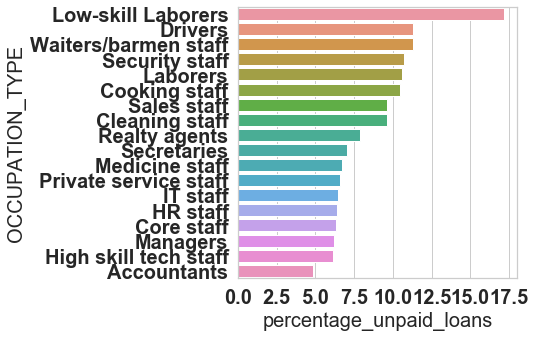

In [43]:
occupation_type_summary = processCategoricalFeature(loan_history_df_pandas, "OCCUPATION_TYPE")
plotPercentageUnpaidLoansPerBin(occupation_type_summary, "OCCUPATION_TYPE", figsize=(5,5), transpose=True)

##### Possible Conclusions

<span>
    <ul>
        <li>
            Most of the loans are approved to "Laborers" class.
        </li>
        <li>
            Loans approved to applicants working in blue collar jobs have higher unpaid loan percentage.
        </li>  
    </ul>
</span>

#### ORGANIZATION_TYPE

In [44]:
organization_type_summary = processCategoricalFeature(loan_history_df_pandas, "ORGANIZATION_TYPE")

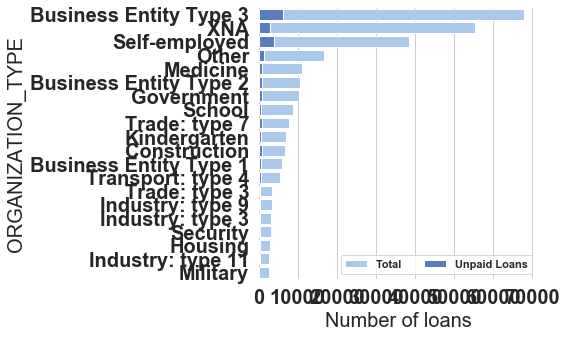

In [45]:
plotTotalAndUnpaidLoansPerBin(organization_type_summary, "ORGANIZATION_TYPE", figsize=(5,5), transpose=True, top_n_intervals=20)

,Total Loans,Unpaid Loans,ORGANIZATION_TYPE,percentage_unpaid_loans
6,1187,187,Transport: type 3,15.754002
47,67,9,Industry: type 13,13.432836
43,24,3,Industry: type 8,12.500000
21,1811,212,Restaurant,11.706240
10,6721,785,Construction,11.679810
32,260,29,Cleaning,11.153846
40,1039,115,Industry: type 1,11.068335
46,3278,348,Industry: type 3,10.616229
41,396,42,Realtor,10.606061
53,2454,257,Agriculture,10.472698


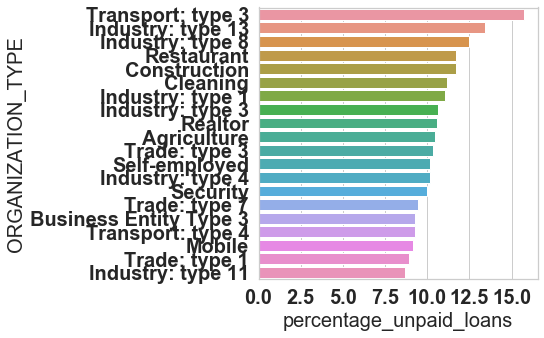

In [46]:
plotPercentageUnpaidLoansPerBin(organization_type_summary, "ORGANIZATION_TYPE", figsize=(5,5), transpose=True)

##### Possible Conclusions

<span>
    <ul>
        <li>
            Businesses seems to be good areas to invest for banks with higher loan repayment rates.
        </li>
        <li>
            Transport and Restaurant have the least loan repayments.
        </li>  
    </ul>
</span>

#### External sources

<Figure size 720x864 with 0 Axes>

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


Text(0.5, 1.0, 'Distribution of EXT_SOURCE_1 by Target Value')

Text(0.5, 0, 'EXT_SOURCE_1')

Text(0, 0.5, 'Density')

Text(0.5, 1.0, 'Distribution of EXT_SOURCE_2 by Target Value')

Text(0.5, 0, 'EXT_SOURCE_2')

Text(0, 0.5, 'Density')

Text(0.5, 1.0, 'Distribution of EXT_SOURCE_3 by Target Value')

Text(0.5, 0, 'EXT_SOURCE_3')

Text(0, 0.5, 'Density')

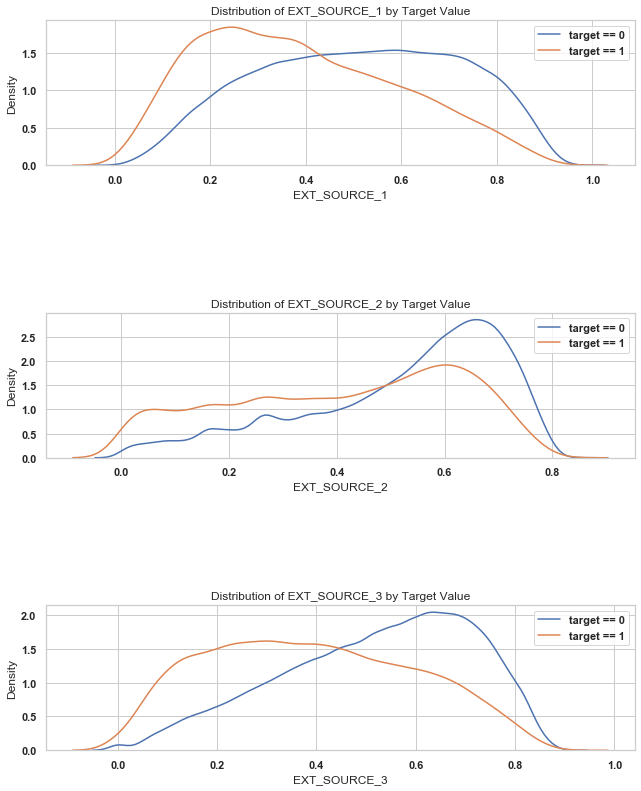

In [47]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(loan_history_df_pandas.loc[loan_history_df_pandas['label'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(loan_history_df_pandas.loc[loan_history_df_pandas['label'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

##### Possible Conclusions

<p>
    EXT_SOURCE_3 displays the greatest difference between the values of the target. We can clearly see that this feature has some relationship to the likelihood of an applicant to repay a loan. The relationship is not very strong (in fact they are all considered very weak, but these variables will still be useful for a machine learning model to predict whether or not an applicant will repay a loan on time
    
</p>

### Correlation Table

,label,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
label,1.000000,0.019187,-0.003982,-0.030369,-0.012817,-0.039645,-0.037227,0.078239,-0.044932,0.041975,...,-0.007952,-0.001358,0.000215,0.003709,0.000930,0.002704,0.000788,-0.012462,-0.002022,0.019930
CNT_CHILDREN,0.019187,1.000000,0.012882,0.002145,0.021374,-0.001827,-0.025573,0.330938,-0.239818,0.183395,...,0.004031,0.000864,0.000988,-0.002450,-0.000410,-0.000366,-0.002436,-0.010808,-0.007836,-0.041550
AMT_INCOME_TOTAL,-0.003982,0.012882,1.000000,0.156870,0.191657,0.159610,0.074796,0.027261,-0.064223,0.027805,...,0.003130,0.002408,0.000242,-0.000589,0.000709,0.002944,0.002387,0.024700,0.004859,0.011690
AMT_CREDIT,-0.030369,0.002145,0.156870,1.000000,0.770138,0.986968,0.099738,-0.055436,-0.066838,0.009621,...,0.034329,0.021082,0.031023,-0.016148,-0.003906,0.004238,-0.001275,0.054451,0.015925,-0.048448
AMT_ANNUITY,-0.012817,0.021374,0.191657,0.770138,1.000000,0.775109,0.118429,0.009445,-0.104332,0.038514,...,-0.009745,0.004573,0.011718,-0.017598,0.003861,0.002185,0.013881,0.039148,0.010124,-0.011320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AMT_REQ_CREDIT_BUREAU_DAY,0.002704,-0.000366,0.002944,0.004238,0.002185,0.004677,0.001399,0.002255,0.000472,-0.000508,...,0.013281,0.001126,-0.000120,-0.001130,0.230374,1.000000,0.217412,-0.005258,-0.004416,-0.003355
AMT_REQ_CREDIT_BUREAU_WEEK,0.000788,-0.002436,0.002387,-0.001275,0.013881,-0.001007,-0.002149,-0.001336,0.003072,-0.001069,...,-0.004640,-0.001275,-0.001770,0.000081,0.004706,0.217412,1.000000,-0.014096,-0.015115,0.018917
AMT_REQ_CREDIT_BUREAU_MON,-0.012462,-0.010808,0.024700,0.054451,0.039148,0.056422,0.078607,0.001372,-0.034457,-0.011353,...,-0.001565,-0.002729,0.001285,-0.003612,-0.000018,-0.005258,-0.014096,1.000000,-0.007789,-0.004975
AMT_REQ_CREDIT_BUREAU_QRT,-0.002022,-0.007836,0.004859,0.015925,0.010124,0.016432,-0.001279,-0.011799,0.015345,-0.001308,...,-0.005125,-0.001575,-0.001010,-0.002004,-0.002716,-0.004416,-0.015115,-0.007789,1.000000,0.076208


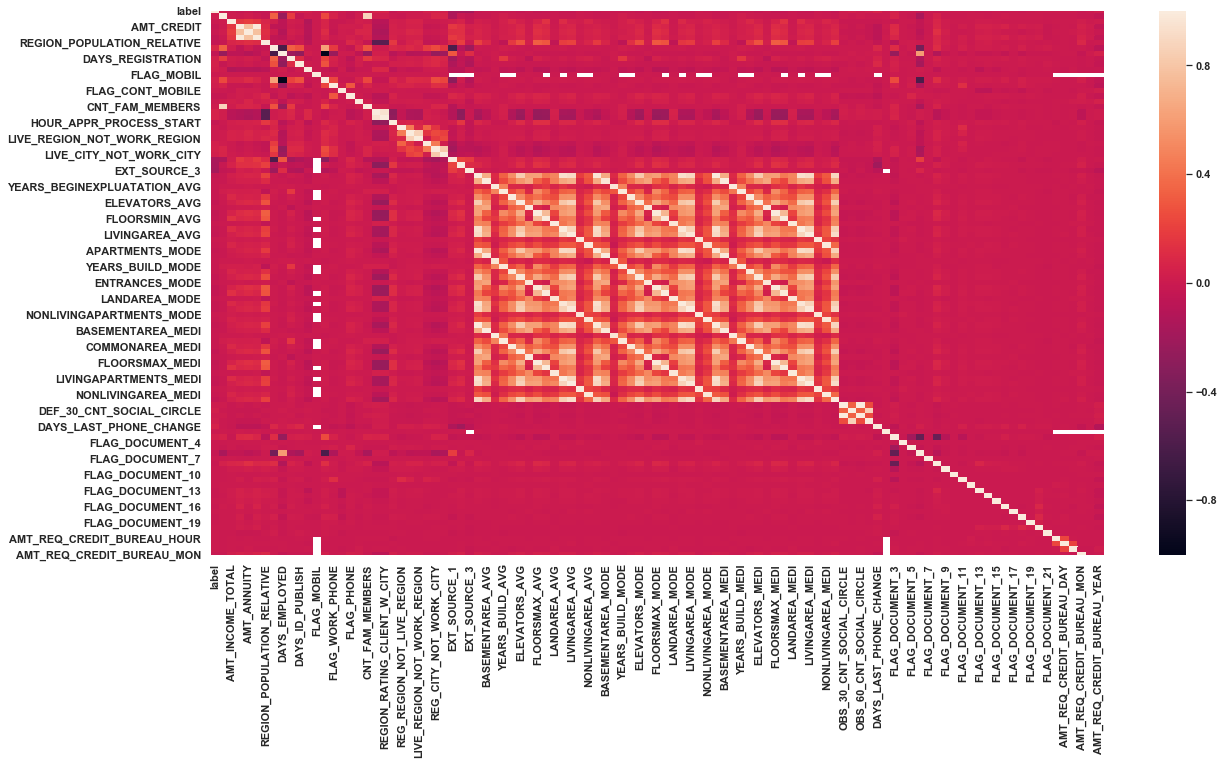

In [48]:
correlation_table = loan_history_df_pandas.corr(method='pearson')
correlation_table
f, axes = plt.subplots(1, 1, figsize=(20, 10))
sns.heatmap(correlation_table, ax=axes)

### Data Cleaning

#### Handling missing data

In [49]:
# now let's see how many categorical and numeirical features we have:
cat_cols = [item[0] for item in loan_history_df.dtypes if item[1].startswith('string')] 
print(str(len(cat_cols)) + '  categorical features')
num_cols = [item[0] for item in loan_history_df.dtypes 
            if item[1].startswith('int') | item[1].startswith('double')][1:]
print(str(len(num_cols)) + '  numerical features')

16  categorical features
104  numerical features


In [50]:
# we use the below function to find more information about the #missing values
def info_missing_table(df_pd):
    """Input pandas dataframe and Return columns with missing value and percentage"""
    mis_val = df_pd.isnull().sum() #count total of null in each columns in dataframe
#count percentage of null in each columns
    mis_val_percent = 100 * df_pd.isnull().sum() / len(df_pd) 
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1) 
 #join to left (as column) between mis_val and mis_val_percent
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'}) 
#rename columns in table
    mis_val_table_ren_columns = mis_val_table_ren_columns[
    mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)
    return mis_val_table_ren_columns

In [51]:
missings = info_missing_table(loan_history_df_pandas)
missings

,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
...,...,...
EXT_SOURCE_2,660,0.2
AMT_GOODS_PRICE,278,0.1
AMT_ANNUITY,12,0.0
CNT_FAM_MEMBERS,2,0.0


In [52]:
cat_cols_with_missing = np.intersect1d(np.array(missings.index), cat_cols)
num_cols_with_missing = np.intersect1d(np.array(missings.index), num_cols)

### Data Imputation

<span>
    <br/>
    <p>
        There are various ways to handle missing data. <br/>
        Since there are very few data points of class 1, removing missing data will make the class even more imbalanced.
    </p>
</span>    

#### Techniques of data Imputation

<ul>
    <li>
        We will fill missing numerical column values with the mean of the column.
    </li>
    <li>
        We will fill missing categorical column values with the most frequent category.
    </li>
</ul>

<a href="https://towardsdatascience.com/6-different-ways-to-compensate-for-missing-values-data-imputation-with-examples-6022d9ca0779"> About Data Imputation </a>

In [53]:
# we will fill the missing numerical column values with the mean of the column
df_Nomiss=loan_history_df.na.drop()
for x in cat_cols_with_missing:
    mode=df_Nomiss.groupBy(x).count().sort(col("count").desc()).collect()[0][0] 
    print(x, mode, sep = ':')
    loan_history_df = loan_history_df.na.fill({x:mode})
# we will fill the missing categorical values with the most frequent category
for i in num_cols_with_missing:
    meanvalue = loan_history_df.select(round(mean(i))).collect()[0][0] 
    print(i, meanvalue, sep = ':') 
    loan_history_df=loan_history_df.na.fill({i:meanvalue})

EMERGENCYSTATE_MODE:No
FONDKAPREMONT_MODE:reg oper account
HOUSETYPE_MODE:block of flats
NAME_TYPE_SUITE:Unaccompanied
OCCUPATION_TYPE:Laborers
WALLSMATERIAL_MODE:Panel
AMT_ANNUITY:27109.0
AMT_GOODS_PRICE:538396.0
AMT_REQ_CREDIT_BUREAU_DAY:0.0
AMT_REQ_CREDIT_BUREAU_HOUR:0.0
AMT_REQ_CREDIT_BUREAU_MON:0.0
AMT_REQ_CREDIT_BUREAU_QRT:0.0
AMT_REQ_CREDIT_BUREAU_WEEK:0.0
AMT_REQ_CREDIT_BUREAU_YEAR:2.0
APARTMENTS_AVG:0.0
APARTMENTS_MEDI:0.0
APARTMENTS_MODE:0.0
BASEMENTAREA_AVG:0.0
BASEMENTAREA_MEDI:0.0
BASEMENTAREA_MODE:0.0
CNT_FAM_MEMBERS:2.0
COMMONAREA_AVG:0.0
COMMONAREA_MEDI:0.0
COMMONAREA_MODE:0.0
DAYS_LAST_PHONE_CHANGE:-963.0
DEF_30_CNT_SOCIAL_CIRCLE:0.0
DEF_60_CNT_SOCIAL_CIRCLE:0.0
ELEVATORS_AVG:0.0
ELEVATORS_MEDI:0.0
ELEVATORS_MODE:0.0
ENTRANCES_AVG:0.0
ENTRANCES_MEDI:0.0
ENTRANCES_MODE:0.0
EXT_SOURCE_1:1.0
EXT_SOURCE_2:1.0
EXT_SOURCE_3:1.0
FLOORSMAX_AVG:0.0
FLOORSMAX_MEDI:0.0
FLOORSMAX_MODE:0.0
FLOORSMIN_AVG:0.0
FLOORSMIN_MEDI:0.0
FLOORSMIN_MODE:0.0
LANDAREA_AVG:0.0
LANDAREA_MEDI:0.0
LA

### Handling imbalanced classes

<b> Techniques to handle imbalanced classes </b>
<ul>
    <li>
        Oversample minority class
    </li>
    <li>
        Undersample majority class
    </li>
</ul>    

<p>
    Class 0 (Loan paid) data points are 80% in the train data.
</p>

In [54]:
loan_history_df.groupby('label').count().toPandas()

,label,count
0,1,24825
1,0,282686


In [55]:
minority_class_df = loan_history_df.filter("label=1")
majority_class_df = loan_history_df.filter("label=0")

# Under-sampling the majority class
sampleRatio = minority_class_df.count() / loan_history_df.count()
majority_class_sample_df = majority_class_df.sample(sampleRatio)

balanced_loan_history = minority_class_df.union(majority_class_sample_df)

In [56]:
balanced_loan_history.groupby('label').count().toPandas()

,label,count
0,1,24825
1,0,22770


### Feature encoding & vectorizing pipeline

In [57]:
stages = []

indexers = [
    StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
    for c in cat_cols
]

encoders = [
    OneHotEncoder(
        inputCol=indexer.getOutputCol(),
        outputCol="{0}_encoded".format(indexer.getOutputCol())) 
    for indexer in indexers
]

allFeatureColumns = []
allFeatureColumns.extend([encoder.getOutputCol() for encoder in encoders])
allFeatureColumns.extend(num_cols)

assembler = VectorAssembler(
    inputCols=allFeatureColumns,
    outputCol="features"
)

stages.extend(indexers)
stages.extend(encoders)
stages.append(assembler)

pipeline = Pipeline(stages=stages)
loan_history_features = pipeline.fit(balanced_loan_history).transform(balanced_loan_history)

train, test = loan_history_features.randomSplit([0.80, 0.20], seed = 42)

print(train.count())
print(test.count())

38247
9348


## Machine Learning Classification Models

In [34]:
modelsAndROCs = []

### Logistic Regression

Text(0, 0.5, 'False Positive Rate')

Text(0.5, 0, 'True Positive Rate')

Text(0.5, 1.0, 'ROC Curve')

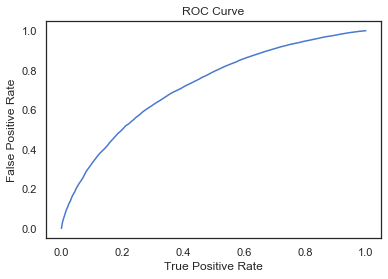

Training set ROC: 0.7199089998687564


In [35]:
# first we check how LogisticRegression perform 
LR = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=15)
LR_model = LR.fit(train)

trainingSummary = LR_model.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set ROC: ' + str(trainingSummary.areaUnderROC))

In [36]:
predictions_LR = LR_model.transform(test)
evaluator = BinaryClassificationEvaluator()
LR_ROC = evaluator.evaluate(predictions_LR, {evaluator.metricName: "areaUnderROC"})
print("Test_SET (Area Under ROC): " + str(LR_ROC))
modelsAndROCs.append(("Logistic Regression", LR_ROC))

Test_SET (Area Under ROC): 0.7207754139532166


### Gradient Boosted Trees

In [37]:
gbt = GBTClassifier(maxIter=15)
GBT_Model = gbt.fit(train)
gbt_predictions = GBT_Model.transform(test)
evaluator = BinaryClassificationEvaluator()
print("Test_SET (Area Under ROC): " + str(evaluator.evaluate(gbt_predictions, {evaluator.metricName: "areaUnderROC"})))

Test_SET (Area Under ROC): 0.7384080094836899


#### Tuning and Cross Validation

In [38]:
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 30])
             .addGrid(gbt.maxIter, [10, 15])
             .build())
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
# Run cross validations.
cvModel = cv.fit(train)
gbt_cv_predictions = cvModel.transform(test)
GBT_ROC = evaluator.evaluate(gbt_cv_predictions)
modelsAndROCs.append(("Gradient Boosted Trees", GBT_ROC))
GBT_ROC

0.733848021858482

### Random Forest

In [39]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=20, maxDepth=2, seed=42)
rf_model = rf.fit(train)
predictions_rf = rf_model.transform(test)
evaluator = BinaryClassificationEvaluator()
print("Test_SET (Area Under ROC): " + str(evaluator.evaluate(predictions_rf, {evaluator.metricName: "areaUnderROC"})))

Test_SET (Area Under ROC): 0.6891706197251994


#### Tuning and Cross Validation

In [40]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features")
paramGrid = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [1, 2])
             .addGrid(rf.numTrees, [5, 50])
             .build())
evaluator = BinaryClassificationEvaluator()
cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
# Run cross validations.
cvModel = cv.fit(train)
rf_cv_predictions = cvModel.transform(test)
RF_ROC = evaluator.evaluate(rf_cv_predictions)
modelsAndROCs.append(("Random Forest", RF_ROC))
RF_ROC

0.7059658634611452

#### Feature Importances

In [41]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

In [42]:
feature_imp_df = ExtractFeatureImp(rf_model.featureImportances, rf_cv_predictions, "features")
feature_imp_df

,idx,name,score
29,150,EXT_SOURCE_3,0.144077
28,149,EXT_SOURCE_2,0.137255
4,125,AMT_GOODS_PRICE,0.099454
6,127,DAYS_BIRTH,0.095567
114,10,NAME_INCOME_TYPE_indexed_encoded_Working,0.067296
...,...,...,...
88,209,FLAG_DOCUMENT_12,0.000000
89,210,FLAG_DOCUMENT_13,0.000000
90,211,FLAG_DOCUMENT_14,0.000000
91,212,FLAG_DOCUMENT_15,0.000000


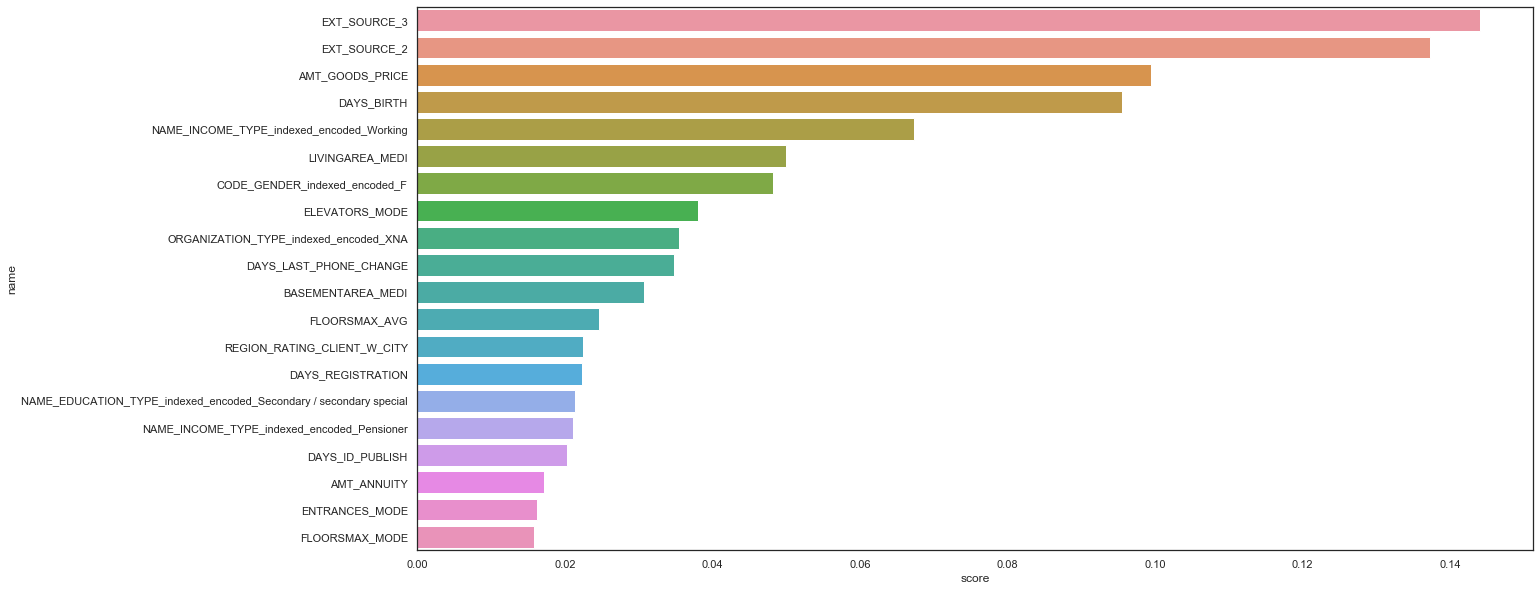

In [43]:
f, axes = plt.subplots(1, 1, figsize=(20, 10))
ax = sns.barplot(x="score", y="name", data=feature_imp_df.head(20), ax=axes)

### Decision Trees

In [44]:
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features",maxDepth=2, seed=42)
dt_model = dt.fit(train)
predictions_dt = dt_model.transform(test)
evaluator = BinaryClassificationEvaluator()
print("Test_SET (Area Under ROC): " + str(evaluator.evaluate(predictions_dt, {evaluator.metricName: "areaUnderROC"})))

Test_SET (Area Under ROC): 0.5827945675028472


#### Tuning and Cross Validation

In [45]:
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")
paramGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [1, 5])
             .addGrid(dt.minInstancesPerNode, [5, 10])
             .build())
evaluator = BinaryClassificationEvaluator()
cv = CrossValidator(estimator=dt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
# Run cross validations.
cvModel = cv.fit(train)
dt_cv_predictions = cvModel.transform(test)
DT_ROC = evaluator.evaluate(dt_cv_predictions)
modelsAndROCs.append(("Decision Tree", DT_ROC))
DT_ROC

0.6139406229010309

### Feedforward Neural Network

In [46]:
no_of_features = loan_history_features.schema["features"].metadata["ml_attr"]["num_attrs"]
layers = [no_of_features,100,60,30,2]
mlp = MultilayerPerceptronClassifier(maxIter=100, layers=layers, seed=123, solver='gd')
mpc_model = mlp.fit(train)
predictions_mpc = mpc_model.transform(test)

predictionAndLabels = predictions_mpc.select("prediction", "label")
evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='label',  metricName='areaUnderROC')
print("Test_SET (Area Under ROC): " + str(evaluator.evaluate(predictionAndLabels)))

Test_SET (Area Under ROC): 0.5078990596618287


#### Tuning and Cross Validation

In [47]:
mlp = MultilayerPerceptronClassifier(maxIter=100, seed=42)
paramGrid = (ParamGridBuilder()
             .addGrid(mlp.solver, ['gd', 'l-bfgs'])
             .addGrid(mlp.layers, [[no_of_features,75,25,2], [no_of_features,50,15,2]])
             .build())
evaluator = BinaryClassificationEvaluator()
cv = CrossValidator(estimator=mlp, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
# Run cross validations.
cvModel = cv.fit(train)
mlp_cv_predictions = cvModel.transform(test)
MLP_ROC = evaluator.evaluate(mlp_cv_predictions)
modelsAndROCs.append(("Multilayer Perceptron", MLP_ROC))
MLP_ROC

0.5657635091478551

### Model performance comparision

,Model,ROC
0,Logistic Regression,0.720775
1,Gradient Boosted Trees,0.733848
2,Random Forest,0.705966
3,Decision Tree,0.613941
4,Multilayer Perceptron,0.565764


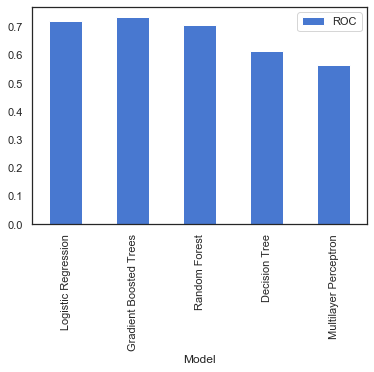

In [60]:
modelsAndROCsDf = pd.DataFrame(data = modelsAndROCs, columns=['Model', 'ROC'])
modelsAndROCsDf
ax = modelsAndROCsDf.plot.bar(x='Model', y='ROC')

#### Model performance comparision

<ul>
    <li>
        Gradient Boosted Trees, Logistic Regression and Random Forest has performed the best among other models.
    </li>
    <li>
        Interestingly, Multilayer Perceptrion has performed the poorest among all other models. <br/>
        This might be because that it is poorly configured.
    </li>
</ul>    

## Conclusion

Following are the factors on which the bankers have to focus more on before approving a loan.
<ul>
    <li>
        EXT_SOURCE_1
    </li>
    <li>
        EXT_SOURCE_2
    </li>
    <li>
        EXT_SOURCE_3
    </li>
    <li>
        Age of the applicant
    </li>
</ul>

## Further improvements

There are a couple of improvements that I could think of to enhance the accuracy of the prediction.

<ul>
    <li>
        <b> Imbalanced Class problem </b> <br/>
        Collect more data points of the applications who have NOT paid the loan
    </li>
</ul>

<ul>
    <li>
        <b> Classification to regression </b> <br/>
        Instead of predicting if an applicant can/cannot pay a loan, an alternative approach would be predict
        the <b> probability/chance of the applicant to repay the loan </b>
    </li>
</ul>